In [3]:
import cv2 
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

In [70]:
img = cv2.imread("temp_img.jpg")
imgcpy= img.copy()
gray = cv2.cvtColor(imgcpy, cv2.COLOR_BGR2GRAY)


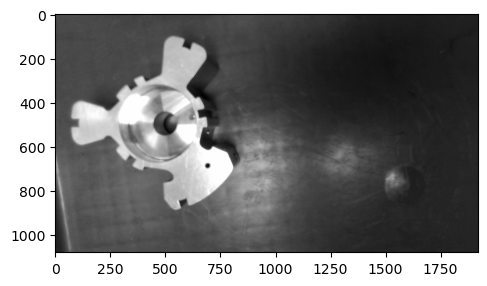

In [71]:
plt.figure(figsize=(12,10))
plt.subplot(1,2,1)
plt.imshow(gray,cmap="gray")

    

In [72]:
blurred_img = cv2.GaussianBlur(gray, (5, 5), 0)
_, thresh_img = cv2.threshold(blurred_img, 0, 255, cv2.THRESH_BINARY + cv2.THRESH_OTSU)


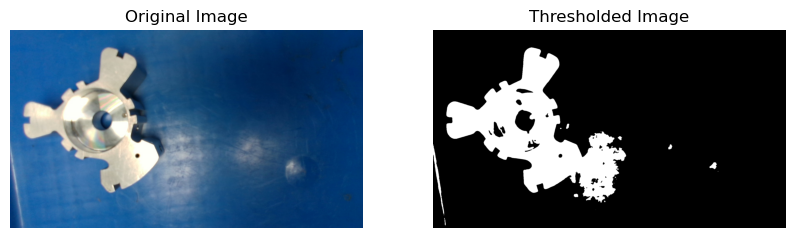

In [73]:
plt.figure(figsize=(10, 5))

plt.subplot(1, 2, 1)
plt.imshow(cv2.cvtColor(img, cv2.COLOR_BGR2RGB))
plt.title('Original Image')
plt.axis('off')

plt.subplot(1, 2, 2)
plt.imshow(thresh_img, cmap='gray')
plt.title('Thresholded Image')
plt.axis('off')

plt.show()

In [74]:
thresh_img = cv2.adaptiveThreshold(blurred_img, 255, cv2.ADAPTIVE_THRESH_MEAN_C, cv2.THRESH_BINARY_INV, 11, 4)

In [75]:
smoothed_img = cv2.GaussianBlur(thresh_img, (5, 5), 0)

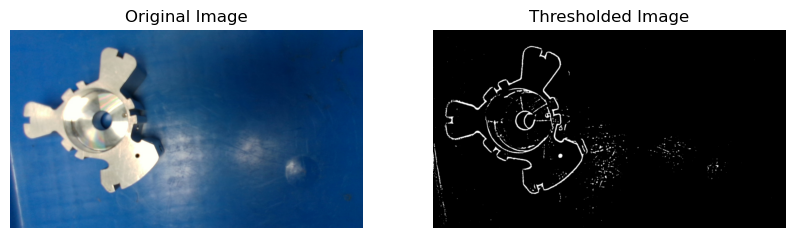

In [76]:
plt.figure(figsize=(10, 5))

plt.subplot(1, 2, 1)
plt.imshow(cv2.cvtColor(img, cv2.COLOR_BGR2RGB))
plt.title('Original Image')
plt.axis('off')

plt.subplot(1, 2, 2)
plt.imshow(smoothed_img, cmap='gray')
plt.title('Thresholded Image')
plt.axis('off')

plt.show()

In [77]:
template_gray = gray.copy()

In [78]:
kernel = np.ones((3,3), np.uint8)
methods = [
    ("Original", template_gray),
    ("Adaptive Thresholding", thresh_img),
    ("Gaussian Filtering", cv2.GaussianBlur(thresh_img, (5, 5), 0)),
    ("Median Filtering", cv2.medianBlur(thresh_img, 5)),
    ("Bilateral Filtering", cv2.bilateralFilter(thresh_img, 9, 75, 75)),
    ("Non-local Means Denoising", cv2.fastNlMeansDenoising(thresh_img, None, 10, 7, 21)),
    ("Morphological Opening", cv2.morphologyEx(thresh_img, cv2.MORPH_OPEN,kernel)),
    ("Wiener Filtering", cv2.warpAffine(thresh_img, cv2.getRotationMatrix2D((template_gray.shape[1]/2, template_gray.shape[0]/2), 30, 1), (template_gray.shape[1], template_gray.shape[0]))),
    ("Anisotropic Diffusion", cv2.filter2D(thresh_img, -1, np.ones((3,3),np.uint8)))
    
]

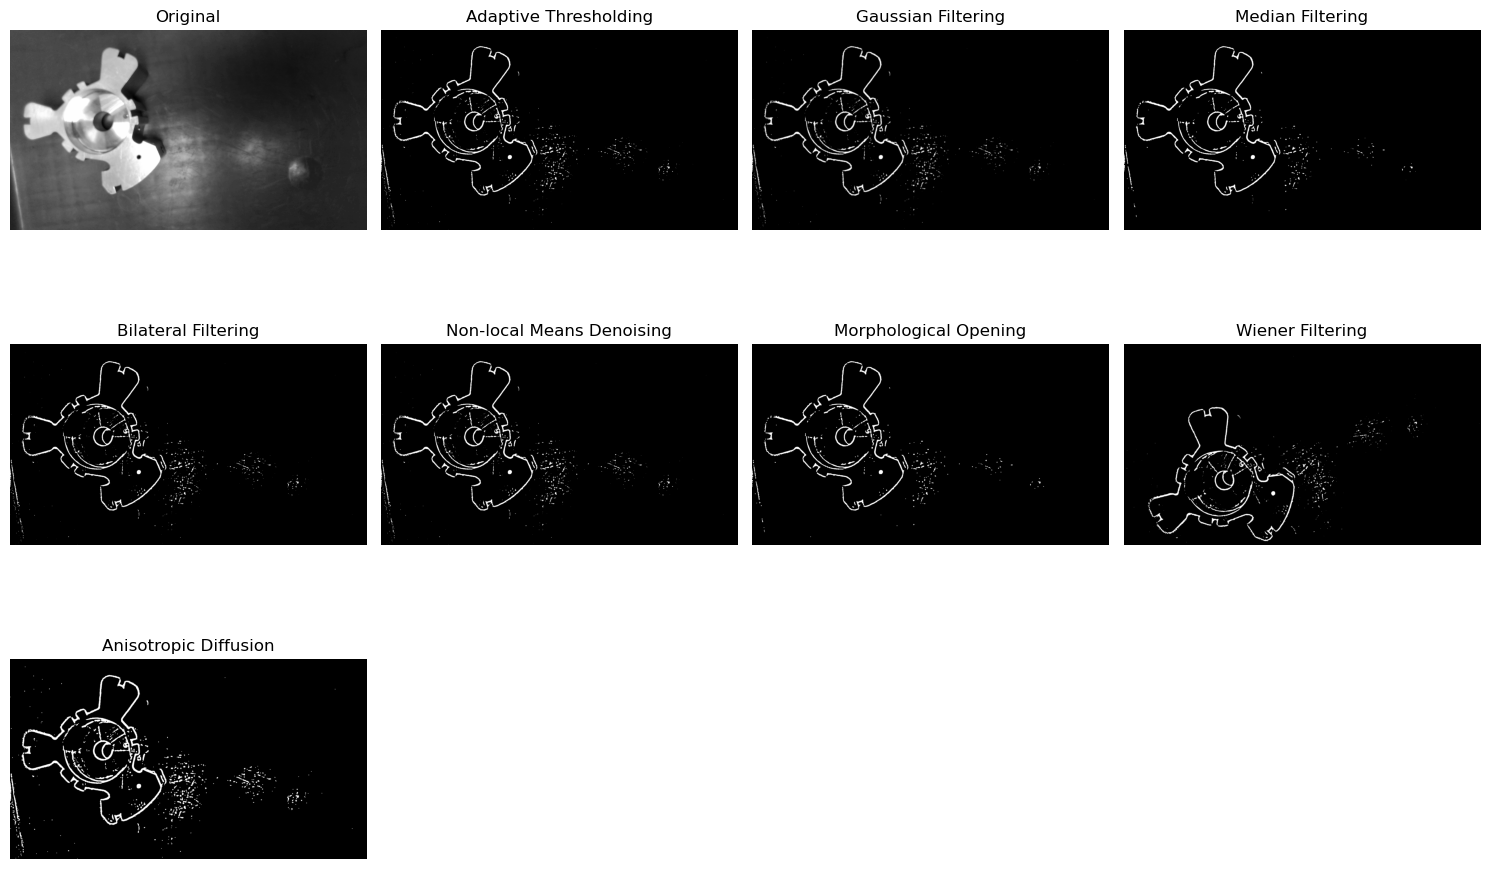

In [79]:
plt.figure(figsize=(15, 10))

for i, (method_name, method_img) in enumerate(methods):
    plt.subplot(3, 4, i + 1)
    plt.imshow(method_img, cmap='gray')
    plt.title(method_name)
    plt.axis('off')

plt.tight_layout()
plt.show()

In [80]:
aniso_img=cv2.filter2D(thresh_img, -1, np.ones((3,3),np.uint8))

In [81]:
contours, _ = cv2.findContours(aniso_img, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)


In [82]:
min_contour_area = 300  # Adjust this threshold as needed
filtered_contours = [cnt for cnt in contours if cv2.contourArea(cnt) > min_contour_area]

In [83]:
contour_mask = np.zeros_like(aniso_img)
cv2.drawContours(contour_mask, filtered_contours, -1, 255, thickness=cv2.FILLED)
filtered_img = cv2.bitwise_and(aniso_img, contour_mask)
final_img=cv2.GaussianBlur(filtered_img, (5, 5), 0)


In [4]:
def display_final_image(img1,img2,img3):

    plt.figure(figsize=(12, 6))

    # Original image
    plt.subplot(1, 3, 1)
    plt.imshow(img1, cmap='gray')
    plt.title("original image")
    plt.axis('off')

    # Thresholded image
    plt.subplot(1, 3, 2)
    plt.imshow(img2, cmap='gray')
    plt.title('img1')
    plt.axis('off')

    # Image after removing small noise
    plt.subplot(1, 3, 3)
    plt.imshow(img3, cmap='gray')
    plt.title('img2')
    plt.axis('off')

    plt.tight_layout()
    plt.show()

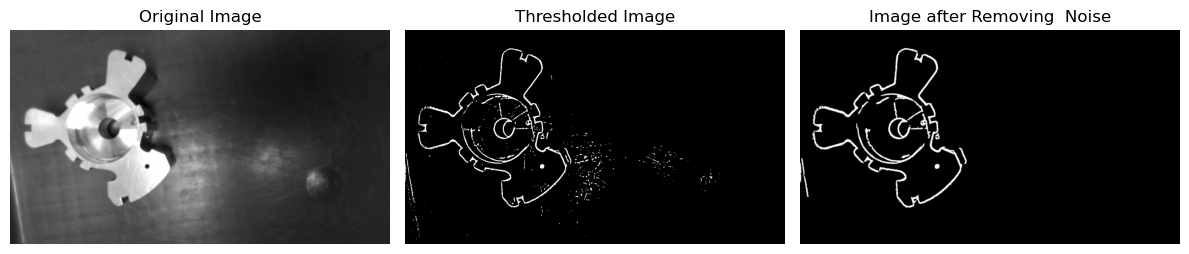

In [86]:
display_final_image(template_gray,thresh_img,final_img)

In [63]:
def estimate_orientation(image):
   
    
    # Compute the moments of the image
    moments = cv2.moments(image)
    
    # Calculate the covariance matrix
    covariance_matrix = np.array([[moments['mu20'], moments['mu11']], [moments['mu11'], moments['mu02']]])
    
    # Compute the eigenvalues and eigenvectors of the covariance matrix
    _, eigenvalues, eigenvectors = np.linalg.svd(covariance_matrix)
    
    # Extract the orientation angle from the eigenvector corresponding to the largest eigenvalue
    orientation_radians = np.arctan2(eigenvectors[0, 1], eigenvectors[0, 0])
    orientation_degrees = np.degrees(orientation_radians)
    
    return orientation_degrees

In [5]:
def preprocessing(img):
    
    gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
    blurred_img = cv2.GaussianBlur(gray, (5, 5), 0)
    thresh_img = cv2.adaptiveThreshold(blurred_img, 255, cv2.ADAPTIVE_THRESH_MEAN_C, cv2.THRESH_BINARY_INV, 11, 4)
    aniso_img=cv2.filter2D(thresh_img, -1, np.ones((3,3),np.uint8))
    contours, _ = cv2.findContours(aniso_img, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)
    min_contour_area = 400  # Adjust this threshold as needed
    filtered_contours = [cnt for cnt in contours if cv2.contourArea(cnt) > min_contour_area]
    contour_mask = np.zeros_like(aniso_img)
    cv2.drawContours(contour_mask, filtered_contours, -1, (255,255,255), thickness=cv2.FILLED)
    filtered_img = cv2.bitwise_and(aniso_img, contour_mask)
    final_img=cv2.GaussianBlur(filtered_img, (5, 5), 0)
    kernel = cv2.getStructuringElement(cv2.MORPH_RECT, (3, 3))
    bin_img = cv2.morphologyEx(final_img, 
                           cv2.MORPH_OPEN,
                           kernel,
                           iterations=2)
    
    return bin_img
    

In [159]:
img1= cv2.imread("temp_img.jpg")
img2= cv2.imread("test_image2.jpg")

preprocessed_img1=preprocessing(img1)
preprocessed_img2=preprocessing(img2)

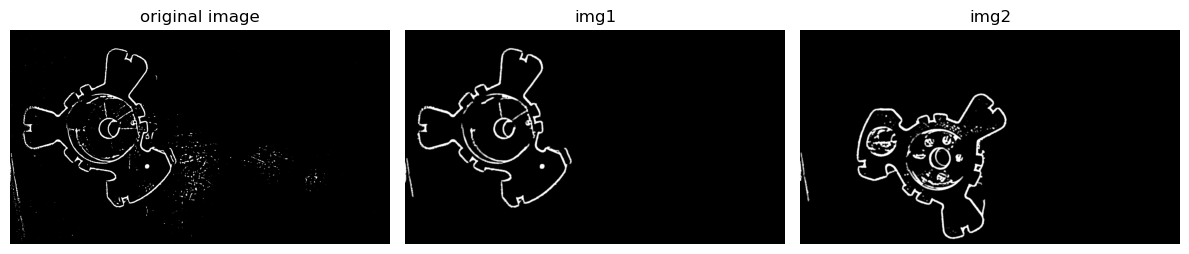

In [160]:
display_final_image(thresh_img,preprocessed_img1,preprocessed_img2)

In [161]:
kernel = cv2.getStructuringElement(cv2.MORPH_RECT, (3, 3))
bin_img1 = cv2.morphologyEx(preprocessed_img1, 
                           cv2.MORPH_OPEN,
                           kernel,
                           iterations=2)
bin_img2 = cv2.morphologyEx(preprocessed_img2, 
                           cv2.MORPH_OPEN,
                           kernel,
                           iterations=2)

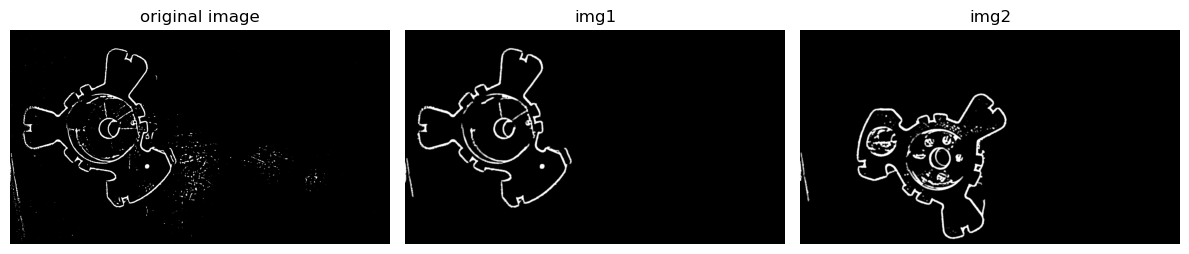

In [162]:
display_final_image(thresh_img,bin_img1,bin_img2)

In [6]:
def preprocessing(img):
    
    gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
    blurred_img = cv2.GaussianBlur(gray, (5, 5), 0)
    thresh_img = cv2.adaptiveThreshold(blurred_img, 255, cv2.ADAPTIVE_THRESH_MEAN_C, cv2.THRESH_BINARY_INV, 11, 4)
    aniso_img=cv2.filter2D(thresh_img, -1, np.ones((3,3),np.uint8))
    contours, _ = cv2.findContours(aniso_img, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)
    min_contour_area = 300  # Adjust this threshold as needed
    filtered_contours = [cnt for cnt in contours if cv2.contourArea(cnt) > min_contour_area]
    contour_mask = np.zeros_like(aniso_img)
    cv2.drawContours(contour_mask, filtered_contours, -1, 255, thickness=cv2.FILLED)
    filtered_img = cv2.bitwise_and(aniso_img, contour_mask)
    final_img=cv2.GaussianBlur(filtered_img, (5, 5), 0)
    kernel = cv2.getStructuringElement(cv2.MORPH_RECT, (3, 3))
    bin_img = cv2.morphologyEx(final_img, cv2.MORPH_OPEN,kernel,iterations=2)
    
    return bin_img

In [7]:
def angle_difference(img1, img2):

  final_img1 = preprocessing(img1.copy())
  final_img2 = preprocessing(img2.copy())

  contours1, _ = cv2.findContours(final_img1, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)
  contours2, _ = cv2.findContours(final_img2, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)

  if len(contours1) > 0 and len(contours2) > 0:
    cnt1 = max(contours1, key=cv2.contourArea)
    cnt2 = max(contours2, key=cv2.contourArea)

    M1 = cv2.moments(cnt1)
    cx1 = int(M1["m10"] / M1["m00"] if M1["m00"] != 0 else 0)
    cy1 = int(M1["m01"] / M1["m00"] if M1["m00"] != 0 else 0)

    M2 = cv2.moments(cnt2)
    cx2 = int(M2["m10"] / M2["m00"] if M2["m00"] != 0 else 0)
    cy2 = int(M2["m01"] / M2["m00"] if M2["m00"] != 0 else 0)

   
    dx = cx2 - cx1
    dy = cy2 - cy1

    
    angle1 = np.arctan2(dy, dx)
    angle1_deg = np.degrees(angle1)

   
    angle_diff_deg = abs(angle1_deg)
    if angle_diff_deg > 180:
      angle_diff_deg = 360 - angle_diff_deg

 
    rgb_img1 = cv2.cvtColor(final_img1, cv2.COLOR_BGR2RGB)
    rgb_img2 = cv2.cvtColor(final_img2, cv2.COLOR_BGR2RGB)

       
    fig, (ax1, ax2) = plt.subplots(1, 2)

      
    ax1.imshow(rgb_img1)
    ax1.axis('off')

       
    ax2.imshow(rgb_img2)
    ax2.axis('off')  

        
    fig.suptitle(f'Estimated Angle Difference: {angle_diff_deg:.2f} degrees')

       
    plt.show()
    
    

    return angle_diff_deg

  




In [8]:
img1= cv2.imread("temp_img.jpg")
img2= cv2.imread("test_image2.jpg")

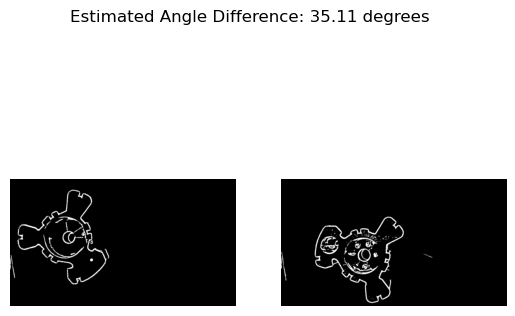

In [166]:

angle_diff = angle_difference(img1, img2)
